# Week 1 Seminar

A/B experiment analysis

In [46]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [47]:
experiment = "USERTRACKEMBD"

In [48]:
data = pd.read_json("/tmp/log/data.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [49]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-04-12 17:47:43.742,3386,20266,1.0,0.010,770.0,{'USERTRACKEMBD': 'T1'},T1
1,next,2023-04-12 17:47:43.745,3386,20266,1.0,0.002,8356.0,{'USERTRACKEMBD': 'T1'},T1
2,next,2023-04-12 17:47:43.747,3386,20266,1.0,0.001,1085.0,{'USERTRACKEMBD': 'T1'},T1
3,next,2023-04-12 17:47:43.750,3386,20266,1.0,0.002,3734.0,{'USERTRACKEMBD': 'T1'},T1
4,next,2023-04-12 17:47:43.753,3386,770,0.0,0.002,140.0,{'USERTRACKEMBD': 'T1'},T1


In [50]:
len(data.user.unique())

2788

In [51]:
data.treatment.value_counts()

T1    21656
C     21056
Name: treatment, dtype: int64

## Visualize sessions

In [52]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [53]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

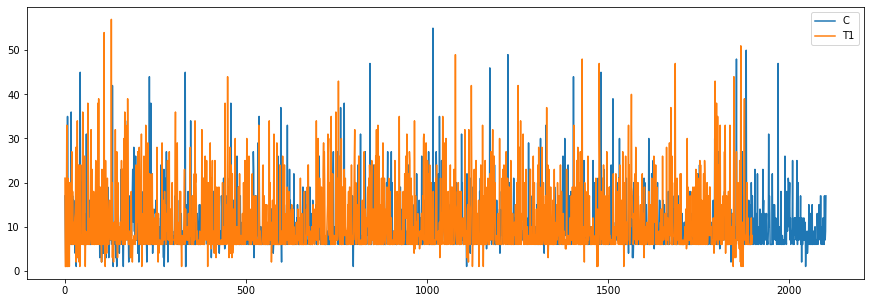

In [54]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

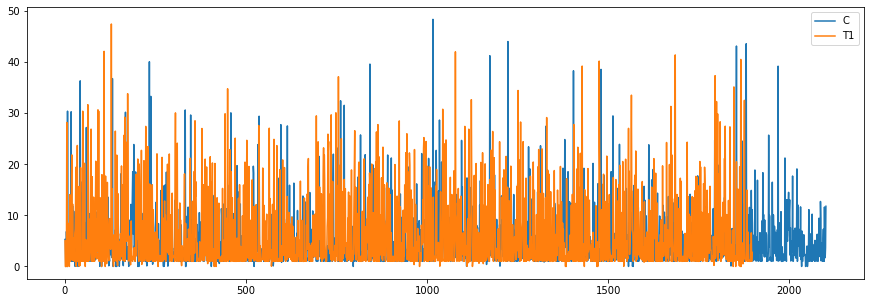

In [55]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [56]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [57]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [58]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [59]:
# a = np.array([3, 4, 1, 2, 5, 2])
# pos = np.argpartition(a, 2)[:2]
# print(pos, a[pos])
# pos[np.argsort(a[pos])]

In [60]:
# user-context * track 40 first vs sem baseline

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,26.797,36.895,16.698,7.209,9.141,True
1,T1,sessions,-1.157,2.619,-4.933,1.443,1.426,False
3,T1,mean_tracks_per_session,14.305,19.005,9.606,10.044,11.481,True
4,T1,mean_time_per_session,28.869,38.096,19.641,5.024,6.474,True
2,T1,mean_request_latency,357.413,367.072,347.754,0.797,3.643,True


In [45]:
# user-context * track 40 first + smart random vs sem baseline

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,110.963,131.365,90.561,6.832,14.412,True
1,T1,sessions,1.107,4.676,-2.463,1.371,1.386,False
3,T1,mean_tracks_per_session,55.474,65.288,45.661,9.998,15.544,True
4,T1,mean_time_per_session,111.365,130.878,91.852,4.989,10.546,True
2,T1,mean_request_latency,346.198,355.190,337.206,0.815,3.638,True


In [30]:
# user-context * track 40 first + smart random

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,92.890,112.457,73.322,7.534,14.531,True
1,T1,sessions,0.092,3.668,-3.484,1.376,1.377,False
3,T1,mean_tracks_per_session,49.929,59.551,40.307,10.424,15.629,True
4,T1,mean_time_per_session,95.817,114.130,77.505,5.441,10.654,True
2,T1,mean_request_latency,345.054,353.966,336.142,0.848,3.775,True


In [15]:
# user-context * track 40 first

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,15.461,25.010,5.911,7.956,9.186,True
1,T1,sessions,1.343,5.146,-2.460,1.388,1.407,False
3,T1,mean_tracks_per_session,7.027,11.684,2.370,10.842,11.604,True
4,T1,mean_time_per_session,13.423,21.943,4.904,5.820,6.602,True
2,T1,mean_request_latency,362.865,372.010,353.720,0.809,3.746,True


In [464]:
# pc first + random + don't repeat + many borders + top10 + border 10.. with clean

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,0.908,8.785,-6.969,6.628,6.688,False
1,T1,sessions,0.513,4.294,-3.268,1.295,1.301,False
3,T1,mean_tracks_per_session,0.974,4.366,-2.418,10.062,10.160,False
4,T1,mean_time_per_session,2.060,8.648,-4.527,5.072,5.176,False
2,T1,mean_request_latency,-16.395,-15.326,-17.464,0.402,0.336,True


In [450]:
# pc first + random + don't repeat + many borders + top10 + border 10..

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,202.207,219.006,185.408,6.934,20.956,True
1,T1,sessions,0.675,3.779,-2.428,1.405,1.414,False
3,T1,mean_tracks_per_session,115.600,125.193,106.007,9.899,21.342,True
4,T1,mean_time_per_session,232.895,252.067,213.723,4.900,16.312,True
2,T1,mean_request_latency,-15.031,-14.258,-15.803,0.412,0.350,True


In [420]:
# pc first + random + don't repeat + many borders + top10 + border 15..

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,216.983,255.977,177.989,5.348,16.953,True
1,T1,sessions,-0.105,2.656,-2.866,1.053,1.052,False
3,T1,mean_tracks_per_session,110.339,130.577,90.101,10.123,21.293,True
4,T1,mean_time_per_session,219.605,259.177,180.033,5.135,16.412,True
2,T1,mean_request_latency,-16.082,-15.195,-16.968,0.428,0.360,True


In [406]:
# pc first + random + don't repeat + many borders + top10

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,196.283,231.529,161.037,5.621,16.654,True
1,T1,sessions,-2.193,0.291,-4.678,1.054,1.030,False
3,T1,mean_tracks_per_session,108.104,127.465,88.742,10.283,21.399,True
4,T1,mean_time_per_session,210.290,247.460,173.120,5.286,16.401,True
2,T1,mean_request_latency,-15.883,-14.899,-16.866,0.447,0.376,True


In [391]:
# pc first + random + don't repeat + many borders + top15

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,206.439,242.436,170.441,5.858,17.953,True
1,T1,sessions,-1.005,1.608,-3.617,1.055,1.044,False
3,T1,mean_tracks_per_session,112.200,131.956,92.443,10.649,22.597,True
4,T1,mean_time_per_session,211.303,248.230,174.377,5.640,17.558,True
2,T1,mean_request_latency,-16.901,-15.982,-17.820,0.434,0.360,True


In [376]:
# pc first + random + don't repeat + many borders + top20

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,242.189,283.731,200.646,5.260,18.001,True
1,T1,sessions,-2.182,0.598,-4.962,1.069,1.046,False
3,T1,mean_tracks_per_session,123.875,145.325,102.425,9.982,22.346,True
4,T1,mean_time_per_session,248.463,290.890,206.036,4.977,17.342,True
2,T1,mean_request_latency,-15.558,-14.629,-16.486,0.440,0.372,True


In [361]:
# pc first + random + don't repeat + many borders

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,245.951,286.359,205.544,5.111,17.680,True
1,T1,sessions,2.462,5.217,-0.293,1.030,1.056,False
3,T1,mean_tracks_per_session,119.433,139.746,99.120,9.956,21.848,True
4,T1,mean_time_per_session,241.691,282.263,201.118,4.944,16.892,True
2,T1,mean_request_latency,-16.883,-15.996,-17.771,0.431,0.358,True


In [346]:
# pc first + random + don't repeat

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,221.412,258.542,184.281,5.278,16.964,True
1,T1,sessions,0.420,3.142,-2.302,1.046,1.050,False
3,T1,mean_tracks_per_session,112.298,131.412,93.183,10.058,21.352,True
4,T1,mean_time_per_session,220.779,258.183,183.375,5.089,16.323,True
2,T1,mean_request_latency,-12.534,-11.639,-13.429,0.431,0.377,True


In [332]:
# pc first + NO random + don't repeat 2

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,236.106,274.886,197.326,5.186,17.429,True
1,T1,sessions,-1.307,1.666,-4.280,1.065,1.051,False
3,T1,mean_tracks_per_session,121.526,141.517,101.536,9.898,21.927,True
4,T1,mean_time_per_session,240.530,279.995,201.066,4.948,16.851,True
2,T1,mean_request_latency,-19.520,-18.694,-20.346,0.428,0.345,True


In [317]:
# pc first + NO random + don't repeat

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,191.642,225.553,157.730,5.290,15.427,True
1,T1,sessions,-0.259,2.622,-3.140,1.057,1.055,False
3,T1,mean_tracks_per_session,100.046,117.681,82.410,9.987,19.978,True
4,T1,mean_time_per_session,201.357,236.344,166.369,4.956,14.934,True
2,T1,mean_request_latency,-17.330,-16.382,-18.279,0.442,0.365,True


In [303]:
# pc first + random + don't repeat

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,213.561,251.843,175.279,5.337,16.735,True
1,T1,sessions,-1.968,0.806,-4.743,1.060,1.039,False
3,T1,mean_tracks_per_session,113.054,133.393,92.715,10.022,21.353,True
4,T1,mean_time_per_session,225.074,265.103,185.045,5.047,16.408,True
2,T1,mean_request_latency,2.608,3.571,1.645,0.461,0.473,True


In [289]:
# pc first + random

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,97.561,116.330,78.792,4.985,9.849,True
1,T1,sessions,1.044,3.466,-1.379,1.033,1.044,False
3,T1,mean_tracks_per_session,46.607,55.913,37.301,9.901,14.515,True
4,T1,mean_time_per_session,95.547,114.023,77.072,4.877,9.536,True
2,T1,mean_request_latency,1.351,2.152,0.550,0.460,0.466,True


In [269]:
# first + random

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,94.431,112.687,76.175,5.557,10.805,True
1,T1,sessions,0.297,3.143,-2.548,1.052,1.055,False
3,T1,mean_tracks_per_session,49.174,58.717,39.630,10.268,15.317,True
4,T1,mean_time_per_session,95.939,114.246,77.632,5.278,10.343,True
2,T1,mean_request_latency,1.650,2.562,0.738,0.459,0.467,True


In [254]:
# firsttrack-track first first train 30 filtered (1000) nd args their nd vs baseline nd norandom

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,281.314,320.780,241.848,6.119,23.334,True
1,T1,sessions,0.403,3.092,-2.286,1.045,1.049,False
3,T1,mean_tracks_per_session,154.657,176.798,132.516,10.867,27.674,True
4,T1,mean_time_per_session,287.858,328.557,247.160,5.862,22.737,True
2,T1,mean_request_latency,285.256,291.568,278.943,0.448,1.726,True


In [239]:
# firsttrack-track first first train 30 filtered (1000) nd args their nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,309.814,353.168,266.461,5.486,22.484,True
1,T1,sessions,0.630,3.271,-2.011,1.044,1.050,False
3,T1,mean_tracks_per_session,161.218,184.273,138.164,10.314,26.943,True
4,T1,mean_time_per_session,312.578,356.782,268.373,5.307,21.894,True
2,T1,mean_request_latency,-13.657,-12.678,-14.636,0.441,0.381,True


In [209]:
# firsttrack-track first first train 30 filtered (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,226.566,246.444,206.688,7.626,24.904,True
1,T1,sessions,-2.372,0.905,-5.649,1.336,1.305,False
3,T1,mean_tracks_per_session,139.985,151.860,128.111,10.746,25.788,True
4,T1,mean_time_per_session,262.473,284.523,240.424,5.731,20.774,True
2,T1,mean_request_latency,344.809,352.469,337.149,0.810,3.602,True


In [179]:
# firsttrack-track first first train 30 not folter (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,19.923,29.226,10.621,7.720,9.259,True
1,T1,sessions,2.367,6.029,-1.294,1.380,1.413,False
3,T1,mean_tracks_per_session,10.787,15.402,6.172,10.585,11.727,True
4,T1,mean_time_per_session,20.233,28.794,11.672,5.609,6.744,True
2,T1,mean_request_latency,330.078,338.769,321.388,0.924,3.974,True


In [164]:
# firsttrack-track first 30 not folter (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-1.437,8.011,-10.884,8.353,8.233,False
1,T1,sessions,-2.552,1.216,-6.319,1.451,1.414,False
3,T1,mean_tracks_per_session,2.679,7.435,-2.077,10.734,11.022,False
4,T1,mean_time_per_session,4.446,13.180,-4.288,5.764,6.020,False
2,T1,mean_request_latency,338.025,346.908,329.143,0.881,3.861,True


In [149]:
# firsttrack-track first 30 (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,14.759,25.273,4.245,7.672,8.804,True
1,T1,sessions,0.144,4.004,-3.716,1.407,1.409,False
3,T1,mean_tracks_per_session,7.301,11.996,2.607,10.421,11.182,True
4,T1,mean_time_per_session,13.426,22.276,4.575,5.458,6.191,True
2,T1,mean_request_latency,314.947,323.360,306.534,0.919,3.813,True


In [134]:
# firsttrack-track (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-0.471,9.424,-10.366,8.063,8.025,False
1,T1,sessions,0.419,4.142,-3.304,1.397,1.403,False
3,T1,mean_tracks_per_session,-0.399,4.250,-5.048,10.710,10.668,False
4,T1,mean_time_per_session,-0.654,7.959,-9.266,5.721,5.684,False
2,T1,mean_request_latency,311.033,319.341,302.726,0.910,3.741,True


In [119]:
# firsttrack-track (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-19.984,-11.601,-28.368,8.690,6.953,True
1,T1,sessions,1.336,5.800,-3.128,1.553,1.573,False
3,T1,mean_tracks_per_session,-9.809,-5.951,-13.667,10.522,9.490,True
4,T1,mean_time_per_session,-19.702,-12.498,-26.906,5.564,4.468,True
2,T1,mean_request_latency,351.013,360.649,341.377,0.874,3.940,True


In [104]:
# user-track (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,10.061,19.206,0.915,8.179,9.002,True
1,T1,sessions,-2.445,1.359,-6.249,1.454,1.419,False
3,T1,mean_tracks_per_session,5.755,10.056,1.455,10.690,11.305,True
4,T1,mean_time_per_session,11.019,19.028,3.011,5.688,6.314,True
2,T1,mean_request_latency,325.933,334.622,317.243,0.893,3.805,True


In [90]:
# 70|30 60 (1000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,10.390,20.365,0.416,8.202,9.054,True
1,T1,sessions,0.876,4.719,-2.967,1.409,1.422,False
3,T1,mean_tracks_per_session,5.815,10.468,1.161,10.790,11.417,True
4,T1,mean_time_per_session,11.238,19.800,2.675,5.775,6.424,True
2,T1,mean_request_latency,324.663,333.671,315.655,0.905,3.843,True


In [60]:
# 70|30 60 (5000) nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,13.137,18.589,7.684,14.208,16.075,True
1,T1,sessions,-1.330,1.309,-3.970,2.482,2.449,False
3,T1,mean_tracks_per_session,7.147,9.615,4.679,10.782,11.553,True
4,T1,mean_time_per_session,13.463,18.018,8.909,5.769,6.546,True
2,T1,mean_request_latency,326.323,330.493,322.153,0.921,3.925,True


In [45]:
# 70|30 60 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,13.480,23.370,3.589,7.905,8.971,True
1,T1,sessions,-0.469,3.313,-4.251,1.409,1.403,False
3,T1,mean_tracks_per_session,7.197,11.878,2.517,10.578,11.339,True
4,T1,mean_time_per_session,13.763,22.524,5.002,5.588,6.357,True
2,T1,mean_request_latency,345.136,354.189,336.084,0.910,4.049,True


In [30]:
# 70|30 60 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,21.623,31.853,11.393,7.770,9.450,True
1,T1,sessions,0.807,4.596,-2.981,1.401,1.413,False
3,T1,mean_tracks_per_session,9.932,14.649,5.215,10.603,11.656,True
4,T1,mean_time_per_session,19.150,27.975,10.326,5.567,6.634,True
2,T1,mean_request_latency,330.189,338.873,321.504,0.905,3.892,True


In [846]:
# 70|30 100 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,11.741,21.918,1.564,8.101,9.052,True
1,T1,sessions,0.882,4.653,-2.889,1.383,1.395,False
3,T1,mean_tracks_per_session,5.810,10.678,0.943,10.876,11.507,True
4,T1,mean_time_per_session,10.837,19.722,1.951,5.854,6.489,True
2,T1,mean_request_latency,355.517,364.434,346.600,0.845,3.847,True


In [831]:
# 70|30 100 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,21.234,31.402,11.066,7.605,9.220,True
1,T1,sessions,-0.867,2.876,-4.610,1.404,1.391,False
3,T1,mean_tracks_per_session,10.833,15.667,6.000,10.476,11.610,True
4,T1,mean_time_per_session,20.579,29.699,11.459,5.477,6.604,True
2,T1,mean_request_latency,377.122,386.010,368.235,0.819,3.909,True


In [816]:
# 70|30 60 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,19.626,29.816,9.435,8.000,9.570,True
1,T1,sessions,-0.261,3.642,-4.165,1.429,1.426,False
3,T1,mean_tracks_per_session,11.206,15.963,6.450,10.545,11.727,True
4,T1,mean_time_per_session,21.626,30.559,12.693,5.552,6.753,True
2,T1,mean_request_latency,377.777,386.908,368.645,0.815,3.895,True


In [802]:
# 70|30 50 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,13.317,23.598,3.036,8.030,9.099,True
1,T1,sessions,-0.650,3.111,-4.410,1.412,1.403,False
3,T1,mean_tracks_per_session,5.778,10.376,1.180,10.676,11.292,True
4,T1,mean_time_per_session,10.658,19.187,2.130,5.686,6.292,True
2,T1,mean_request_latency,355.751,364.454,347.047,0.934,4.255,True


In [787]:
# 70|30 40 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,18.269,28.118,8.420,7.826,9.256,True
1,T1,sessions,2.446,6.170,-1.277,1.389,1.423,False
3,T1,mean_tracks_per_session,7.316,12.004,2.627,10.699,11.482,True
4,T1,mean_time_per_session,14.681,23.412,5.949,5.648,6.478,True
2,T1,mean_request_latency,370.847,379.723,361.972,0.799,3.762,True


In [727]:
# 70|30 40 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,16.364,26.330,6.399,7.901,9.194,True
1,T1,sessions,1.929,5.815,-1.957,1.414,1.441,False
3,T1,mean_tracks_per_session,6.393,10.953,1.833,10.603,11.281,True
4,T1,mean_time_per_session,12.138,20.647,3.630,5.622,6.304,True
2,T1,mean_request_latency,339.045,347.518,330.573,0.867,3.807,True


In [628]:
# 70|30 40 nd args vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,11.010,15.287,6.732,23.836,26.460,True
1,T1,sessions,-0.973,1.202,-3.147,4.164,4.123,False
3,T1,mean_tracks_per_session,6.589,8.506,4.672,10.718,11.424,True
4,T1,mean_time_per_session,12.485,16.036,8.934,5.711,6.424,True
2,T1,mean_request_latency,368.348,371.552,365.144,0.862,4.036,True


In [385]:
# 70|30 30 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,4.495,9.620,-0.630,14.173,14.810,False
1,T1,sessions,-0.739,1.922,-3.400,2.490,2.472,False
3,T1,mean_tracks_per_session,3.069,5.343,0.796,10.630,10.956,True
4,T1,mean_time_per_session,5.649,9.883,1.415,5.625,5.943,True
2,T1,mean_request_latency,370.595,374.735,366.454,0.872,4.105,True


In [371]:
# 70|30 30 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,7.723,11.906,3.539,23.187,24.978,True
1,T1,sessions,1.246,3.453,-0.960,4.113,4.165,False
3,T1,mean_tracks_per_session,2.769,4.607,0.932,10.683,10.979,True
4,T1,mean_time_per_session,5.157,8.573,1.741,5.686,5.980,True
2,T1,mean_request_latency,369.645,372.734,366.556,0.828,3.890,True


In [357]:
# 70|30 30 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,5.491,10.638,0.345,14.020,14.790,True
1,T1,sessions,0.109,2.764,-2.546,2.471,2.474,False
3,T1,mean_tracks_per_session,2.999,5.271,0.728,10.666,10.985,True
4,T1,mean_time_per_session,5.783,9.999,1.568,5.664,5.992,True
2,T1,mean_request_latency,366.534,370.852,362.216,0.828,3.863,True


In [343]:
# 70|30 25 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,3.330,8.347,-1.687,13.979,14.445,False
1,T1,sessions,-0.430,2.237,-3.097,2.475,2.465,False
3,T1,mean_tracks_per_session,2.179,4.435,-0.077,10.666,10.898,False
4,T1,mean_time_per_session,4.098,8.297,-0.101,5.650,5.882,False
2,T1,mean_request_latency,363.487,367.734,359.241,0.838,3.882,True


In [329]:
# 70|30 25 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,2.362,7.382,-2.658,14.071,14.404,False
1,T1,sessions,-0.368,2.293,-3.030,2.484,2.475,False
3,T1,mean_tracks_per_session,2.601,4.866,0.336,10.668,10.945,True
4,T1,mean_time_per_session,4.813,9.013,0.613,5.665,5.938,True
2,T1,mean_request_latency,354.198,358.265,350.132,0.858,3.896,True


In [315]:
# 70|30 25 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,6.753,15.626,-2.120,7.687,8.207,False
1,T1,sessions,-1.944,1.794,-5.681,1.422,1.394,False
3,T1,mean_tracks_per_session,5.014,9.163,0.864,10.450,10.974,True
4,T1,mean_time_per_session,9.883,17.724,2.041,5.435,5.972,True
2,T1,mean_request_latency,368.236,377.334,359.138,0.822,3.848,True


In [301]:
# 70|30 15 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-7.183,1.315,-15.681,8.153,7.567,False
1,T1,sessions,-2.737,0.932,-6.405,1.447,1.408,False
3,T1,mean_tracks_per_session,-2.186,1.738,-6.111,10.607,10.375,False
4,T1,mean_time_per_session,-4.019,3.294,-11.332,5.615,5.389,False
2,T1,mean_request_latency,336.705,345.149,328.260,0.847,3.698,True


In [287]:
# 70|30 10 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-16.451,-8.653,-24.249,8.033,6.711,True
1,T1,sessions,-0.736,3.002,-4.475,1.425,1.415,False
3,T1,mean_tracks_per_session,-8.765,-5.122,-12.408,10.691,9.754,True
4,T1,mean_time_per_session,-16.723,-10.009,-23.438,5.700,4.747,True
2,T1,mean_request_latency,323.451,330.785,316.116,1.069,4.525,True


In [272]:
# 70|30 20 nd vs baseline nd

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,3.981,12.795,-4.833,8.074,8.395,False
1,T1,sessions,-0.730,2.929,-4.389,1.411,1.401,False
3,T1,mean_tracks_per_session,4.221,8.334,0.108,10.624,11.072,True
4,T1,mean_time_per_session,7.115,14.718,-0.487,5.663,6.066,False
2,T1,mean_request_latency,322.391,329.625,315.157,1.072,4.529,True


In [258]:
# 70|30 20 nd vs baseline od

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,13.558,22.669,4.448,7.240,8.221,True
1,T1,sessions,3.449,7.329,-0.432,1.386,1.434,False
3,T1,mean_tracks_per_session,4.652,8.598,0.707,10.219,10.694,True
4,T1,mean_time_per_session,8.737,16.319,1.156,5.231,5.689,True
2,T1,mean_request_latency,334.382,342.334,326.430,0.976,4.238,True


In [244]:
# 70|30 20 vs baseline

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-7.738,0.522,-15.997,7.240,6.680,False
1,T1,sessions,-0.668,3.086,-4.423,1.426,1.417,False
3,T1,mean_tracks_per_session,-2.957,0.898,-6.811,10.069,9.771,False
4,T1,mean_time_per_session,-5.661,1.834,-13.155,5.068,4.781,False
2,T1,mean_request_latency,378.198,386.559,369.837,0.964,4.611,True


In [216]:
# 70|30 5

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,101.138,114.837,87.440,3.180,6.397,True
1,T1,sessions,-0.348,3.677,-4.373,1.517,1.511,False
3,T1,mean_tracks_per_session,30.160,33.692,26.627,7.123,9.271,True
4,T1,mean_time_per_session,102.187,113.676,90.698,2.114,4.274,True
2,T1,mean_request_latency,495.181,506.916,483.446,0.691,4.110,True


In [202]:
# 70|30 10

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,137.184,153.163,121.206,3.059,7.255,True
1,T1,sessions,0.295,4.300,-3.709,1.475,1.479,False
3,T1,mean_tracks_per_session,40.360,44.547,36.173,7.101,9.967,True
4,T1,mean_time_per_session,136.868,150.647,123.088,2.090,4.951,True
2,T1,mean_request_latency,480.373,491.515,469.231,0.687,3.988,True


In [230]:
# 70|30 15

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,145.246,163.716,126.776,3.035,7.442,True
1,T1,sessions,1.851,5.939,-2.237,1.481,1.509,False
3,T1,mean_tracks_per_session,40.693,45.113,36.272,7.025,9.884,True
4,T1,mean_time_per_session,140.390,155.262,125.517,2.041,4.905,True
2,T1,mean_request_latency,471.979,483.853,460.104,0.698,3.991,True


In [188]:
# 70|30 20

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,125.586,141.338,109.835,3.136,7.075,True
1,T1,sessions,-2.961,0.958,-6.880,1.484,1.440,False
3,T1,mean_tracks_per_session,40.344,44.664,36.024,7.090,9.951,True
4,T1,mean_time_per_session,137.467,151.752,123.182,2.097,4.980,True
2,T1,mean_request_latency,496.782,509.379,484.185,0.682,4.071,True


In [174]:
# 70|30 50

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,125.038,142.121,107.956,3.144,7.075,True
1,T1,sessions,-1.896,2.100,-5.891,1.503,1.474,False
3,T1,mean_tracks_per_session,37.440,41.825,33.055,7.064,9.709,True
4,T1,mean_time_per_session,128.309,142.919,113.699,2.072,4.730,True
2,T1,mean_request_latency,465.614,475.533,455.694,0.854,4.832,True


In [160]:
# 70|30 100

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,114.767,131.324,98.209,3.103,6.665,True
1,T1,sessions,0.506,4.620,-3.607,1.501,1.509,False
3,T1,mean_tracks_per_session,33.625,37.923,29.327,7.070,9.447,True
4,T1,mean_time_per_session,114.674,128.828,100.520,2.086,4.478,True
2,T1,mean_request_latency,539.023,550.324,527.723,0.739,4.725,True


In [146]:
# 20|80 5

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,126.514,143.009,110.020,3.144,7.121,True
1,T1,sessions,0.860,4.935,-3.215,1.488,1.501,False
3,T1,mean_tracks_per_session,37.221,41.432,33.010,7.115,9.764,True
4,T1,mean_time_per_session,126.657,140.467,112.846,2.105,4.771,True
2,T1,mean_request_latency,492.491,502.840,482.141,0.794,4.704,True


In [132]:
# 20|80 10

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,142.932,159.499,126.365,2.976,7.230,True
1,T1,sessions,-0.058,4.137,-4.252,1.476,1.475,False
3,T1,mean_tracks_per_session,42.471,46.826,38.117,6.970,9.930,True
4,T1,mean_time_per_session,145.296,160.089,130.503,2.012,4.935,True
2,T1,mean_request_latency,467.316,478.486,456.146,0.713,4.045,True


In [118]:
# 20|80 20

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,138.117,156.355,119.878,3.128,7.448,True
1,T1,sessions,0.470,4.467,-3.527,1.491,1.498,False
3,T1,mean_tracks_per_session,39.221,43.877,34.566,7.107,9.894,True
4,T1,mean_time_per_session,132.984,148.297,117.671,2.103,4.900,True
2,T1,mean_request_latency,537.570,548.299,526.841,0.750,4.781,True


In [104]:
# 20|80 50

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,133.274,150.793,115.756,3.096,7.222,True
1,T1,sessions,2.889,7.247,-1.470,1.493,1.536,False
3,T1,mean_tracks_per_session,36.991,41.436,32.547,7.108,9.737,True
4,T1,mean_time_per_session,125.978,140.523,111.433,2.088,4.719,True
2,T1,mean_request_latency,520.781,531.499,510.063,0.775,4.813,True


In [90]:
# 20|80 100

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,106.417,121.956,90.878,3.098,6.395,True
1,T1,sessions,1.939,6.139,-2.261,1.469,1.497,False
3,T1,mean_tracks_per_session,29.841,33.868,25.814,7.101,9.220,True
4,T1,mean_time_per_session,99.284,112.414,86.153,2.105,4.196,True
2,T1,mean_request_latency,427.816,437.148,418.483,0.934,4.929,True


In [76]:
# 50/50 5

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,97.827,111.518,84.135,3.271,6.471,True
1,T1,sessions,-5.752,-1.883,-9.621,1.510,1.423,True
3,T1,mean_tracks_per_session,33.696,37.484,29.907,7.154,9.564,True
4,T1,mean_time_per_session,113.771,126.129,101.413,2.140,4.574,True
2,T1,mean_request_latency,489.637,501.346,477.928,0.677,3.989,True


In [59]:
# 50/50 10

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,134.817,153.343,116.290,3.108,7.298,True
1,T1,sessions,-1.441,2.683,-5.565,1.515,1.493,False
3,T1,mean_tracks_per_session,38.407,42.887,33.927,7.090,9.813,True
4,T1,mean_time_per_session,128.582,143.347,113.818,2.101,4.803,True
2,T1,mean_request_latency,441.059,450.075,432.043,0.955,5.169,True


In [45]:
# 50/50 20

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,116.311,131.610,101.013,3.175,6.867,True
1,T1,sessions,-1.615,2.473,-5.703,1.509,1.484,False
3,T1,mean_tracks_per_session,38.014,42.361,33.667,7.089,9.784,True
4,T1,mean_time_per_session,127.425,141.773,113.078,2.098,4.772,True
2,T1,mean_request_latency,409.142,418.118,400.166,0.990,5.038,True


In [31]:
# 50/50 100

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,113.551,129.826,97.276,3.070,6.555,True
1,T1,sessions,1.428,5.542,-2.687,1.481,1.502,False
3,T1,mean_tracks_per_session,32.310,36.338,28.283,7.058,9.339,True
4,T1,mean_time_per_session,110.305,123.690,96.920,2.074,4.361,True
2,T1,mean_request_latency,490.763,502.928,478.598,0.678,4.006,True


#### sdfsdfsdf

In [110]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,121.730,136.730,106.730,3.218,7.135,True
1,T1,sessions,-1.572,2.421,-5.565,1.492,1.468,False
3,T1,mean_tracks_per_session,39.133,43.302,34.963,7.159,9.961,True
4,T1,mean_time_per_session,129.569,143.004,116.133,2.155,4.947,True
2,T1,mean_request_latency,37.467,38.780,36.154,0.292,0.402,True


In [14]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,47.862,55.687,40.036,3.423,5.062,True
1,T1,sessions,0.198,4.695,-4.300,1.589,1.592,False
3,T1,mean_tracks_per_session,13.955,15.647,12.263,7.133,8.128,True
4,T1,mean_time_per_session,47.725,52.397,43.053,2.125,3.139,True
2,T1,mean_request_latency,46.569,48.002,45.136,0.293,0.429,True
